# Machine learning-based fabrication constraints for inverse design using PreFab

This notebook demonstrates how to apply advanced fabrication constraint correction to photonic devices generated through inverse design. We'll show the integration of `Tidy3D` with `PreFab`, a python-based tool that uses machine learning to correct problematic device features, which leads to a more robust improvement of the device when fabricated.

> To install the `jax` module required for this feature, we recommend running `pip install "tidy3d[jax]"`.

We build on the approach detailed in the previous [notebook](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/AdjointPlugin6GratingCoupler.html) on the inverse design of a compact grating coupler. In that notebook, we include a feature size filter and penalty to achieve a higher-performing device in simulation. In this notebook, we use [PreFab's](https://prefabphotonics.com/) machine learning (ML) capabilities on a device designed without feature size penalties and correct any resulting fabrication variations of the fine features post-optimization. The outcome is a design that is optimized for high on-chip performance by using the advanced design capabilities provided by [Tidy3D's adjoint plugin](../notebooks/AdjointPlugin1Intro.html) and PreFab's nanofabrication prediction [Python package](https://github.com/PreFab-Photonics/PreFab).

PreFab uses hundreds of design patterns, encompassing a wide array of feature types and distributions (similar to those found in inverse-designed devices) to develop a comprehensive model of the nanofabrication process specific to a given foundry. This model predicts the fabrication process, enabling it to identify and correct any deviations (e.g., corner rounding, erosion, dilation, feature loss) that might occur. Consequently, creates designs that are not only optimized for superior performance but are also resilient to the inconsistencies inherent in the fabrication process. The image below illustrates a sample randomized pattern, its predicted fabrication outcome, the actual fabrication result, and the subsequent corrections made. In this notebook, this methodology will be applied to a pre-optimized, fine-featured grating coupler inverse design, showcasing the advantages of integrating PreFab into the design workflow.

Note that PreFab models are continuously evolving, with enhancements and updates anticipated regularly. To delve deeper into the details of ML-driven nanofabrication prediction and to remain informed on the latest developments, visit PreFab's [website](https://www.prefabphotonics.com/) and [GitHub repository](https://github.com/PreFab-Photonics).

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.


We start by importing our typical python packages.


In [1]:
# Standard python imports.
import numpy as np
import matplotlib.pylab as plt

# Import regular tidy3d.
import tidy3d as td
import tidy3d.web as web

## Set up PreFab

**PreFab** is a Python package that employs **deep learning** to predict and correct for fabrication-induced structural variations in integrated photonic devices. This _virtual nanofabrication environment_ provides crucial insights into nanofabrication processes, thereby helping improve the precision of device designs.

This becomes particularly important for inverse-designed devices such as this grating coupler, which often feature many small, intricate features. These complex features can be significantly affected by the slightest variations in the fabrication process.

In this demonstration, we'll use PreFab to predict and correct the fabrication-induced variations in the final grating coupler design. We'll also use the stochastic uncertainty inherent in the prediction to evaluate the design's robustness, both pre and post-correction. This step ensures the design withstands the natural variability of the nanofabrication process, thereby boosting the reliability and expected performance.


The following terms are used throughout the rest of the notebook:

- **Prediction**: The process of predicting the structural variations in the design due to the fabrication process.
- **Correction**: The process of correcting the design to compensate for the predicted structural variations.
- **Outcome**: The prediction of the corrected design.
- **(Un)Constrained**: We analyze the prefab corrections on previously optimized grating couplers. Whether a design is "constrained" or "unconstrained" refers to whether or not we applied feature size penalties (constraints) to the optimization model.

Below is an example of a simple target design, its predicted structure after fabrication, the corrected design, and the predicted structure after fabrication of the correction (outcome). With PreFab, the Intersect over Union (IoU) between the predicted and the nominal design starts at `IoU = 0.65`. After applying corrections, the IoU between the outcome and the nominal design rises to `IoU = 0.97`.

![PreFab Target Example](img/prefab_target.png)

Here is another example with a more complex geometry, including the fabricated results, showing good agreement with the corrected model.

![PreFab Intro](img/prefab_intro.png)

We will apply these same benefits to our grating coupler design.


First, install the latest PreFab Python package.


In [ ]:
%pip install --upgrade prefab

PreFab models operate on a serverless cloud platform. To initiate prediction requests, you must first create an account.


In [ ]:
import webbrowser

_ = webbrowser.open("https://www.prefabphotonics.com/signup")

To associate your account, a token is required. This action will prompt a browser window to open, allowing you to log in and validate your token.


In [ ]:
!python3 -m prefab setup

## Load starting designs

The pre-optimized device is loaded from a GDS file included in `misc/`, showcasing numerous intricate features that stand in contrast to those in the previous notebook. Ideally, we should include the waveguide at this stage due to potential interface variations. However, for the sake of this demonstration, we'll simplify the process.

First, let's set some global variables defining where the files will be stored.


In [2]:
# gds file storing original design, and where we'll write the final design in a new cell
GDS_FILE = "misc/prefab_gc.gds"
GDS_CELL_START = "gc"
GDS_CELL_FINAL = "gc_tidy_prefab"

# base tidy3d.Simulation (without grating coupler)
SIM_BASE_FILE = "misc/prefab_base_sim.hdf5"

The `hdf5` file stores a base `td.Simulation` with no grating coupler added. We'll use this as the starting point for our analysis.

The grating coupler structure converts a vertically incident Gaussian-like mode from an optical fiber into a guided mode and then funnels it into the $Si$ waveguide. We are considering a full-etched grating structure, so a $SiO_{2}$ BOX layer is included. To reduce backreflection, we adjusted the fiber tilt angle to $10^{\circ}$ [[1](https://doi.org/10.1364/OE.23.022628), [2](https://doi.org/10.3390/mi11070666)].

Let's visualize it below.


In [3]:
# load the base simulation (no grating coupler)
sim_base = td.Simulation.from_file(SIM_BASE_FILE)

sim_base.plot_3d()

08:38:00 EDT WARNING: updating Simulation from 2.5 to 2.6                       

The `gds` file stores our starting device, which was obtained from the grating coupler inverse design [notebook](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/AdjointPlugin6GratingCoupler.html) with no extra fabrication penalty included.


<Axes: xlabel='x (nm)', ylabel='y (nm)'>

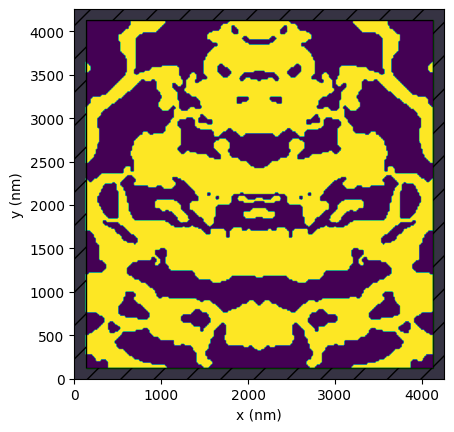

In [4]:
import prefab as pf

device = pf.read.from_gds(gds_path=GDS_FILE, cell_name=GDS_CELL_START)
device.plot()

We can combine the base simulation and the device design with the following function, which takes a `device` array, constructs a `td.Structure` and adds it to a copy of the base `Simulation`.


In [5]:
def make_simulation(device: np.ndarray) -> td.Simulation:
    """Add a grating coupler from a given device array."""

    # grab some material and geometric parameters from the base simulation and waveguide
    waveguide = sim_base.structures[0]
    eps_min = sim_base.medium.permittivity
    eps_max = waveguide.medium.permittivity
    w_thick = waveguide.geometry.size[2]

    # construct the grating coupler out of the parameters
    eps_values = eps_min + (eps_max - eps_min) * device
    dev_width = device.shape[1] / 1000
    dev_height = device.shape[0] / 1000
    Nx, Ny = eps_values.shape
    X = np.linspace(-dev_width / 2, dev_width / 2, Nx)
    Y = np.linspace(-dev_height / 2, dev_height / 2, Ny)
    Z = np.array([0])
    eps_array = td.SpatialDataArray(
        np.expand_dims(eps_values, axis=-1), coords=dict(x=X, y=Y, z=Z)
    )
    gc = td.Structure(
        geometry=td.Box(center=(0, 0, 0), size=(td.inf, td.inf, w_thick)),
        medium=td.CustomMedium.from_eps_raw(eps_array),
    )

    # return a copy of the base simulation with the grating coupler added (make sure it's added FIRST as it overwrites others)
    all_structures = [gc] + list(sim_base.structures)

    return sim_base.updated_copy(structures=all_structures)

Let's test this function out and view our starting, un-corrected device.


In [6]:
sim = make_simulation(device.to_ndarray())

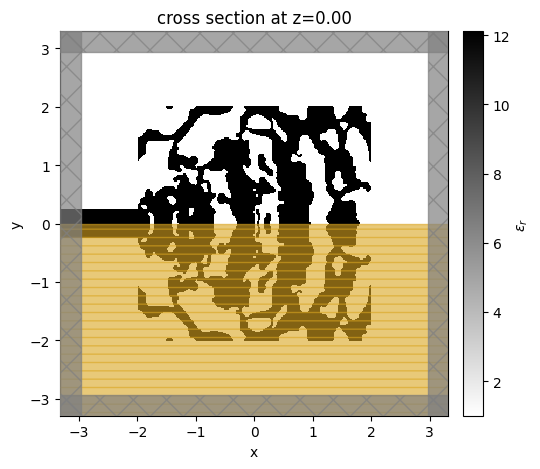

In [7]:
ax = sim.plot_eps(z=0, monitor_alpha=0.0)

> note: the orange box indicates a symmetry region.


## Apply PreFab models


We're now ready to predict, correct, and anticipate the final outcome of the device using a model based on [Applied Nanotools'](https://www.appliednt.com/nanosoi-fabrication-service/) silicon photonics process. The prediction will take a few seconds to complete.


In [8]:
MODEL_NAME = "ANT_NanoSOI_ANF1_d9"

prediction = device.predict(model=pf.models[MODEL_NAME], binarize=False)

Prediction: 100%|██████████████████████████████| 100/100 [00:37<00:00,  2.66%/s]


In [9]:
correction = device.correct(model=pf.models[MODEL_NAME], binarize=True)
outcome = correction.predict(model=pf.models[MODEL_NAME], binarize=False)

Prediction: 100%|██████████████████████████████| 100/100 [00:32<00:00,  3.09%/s]


Now we plot the predictions and corrections. Upon a closer look at the device's variations, we see several fuzzy areas around the edges of the prediction. These fuzzy spots represent areas of uncertainty in the design and the expected variance on the chip, especially in smaller, complex features. The prediction also shows many rounded corners, bridged gaps, and filled holes, indicating further changes during fabrication.


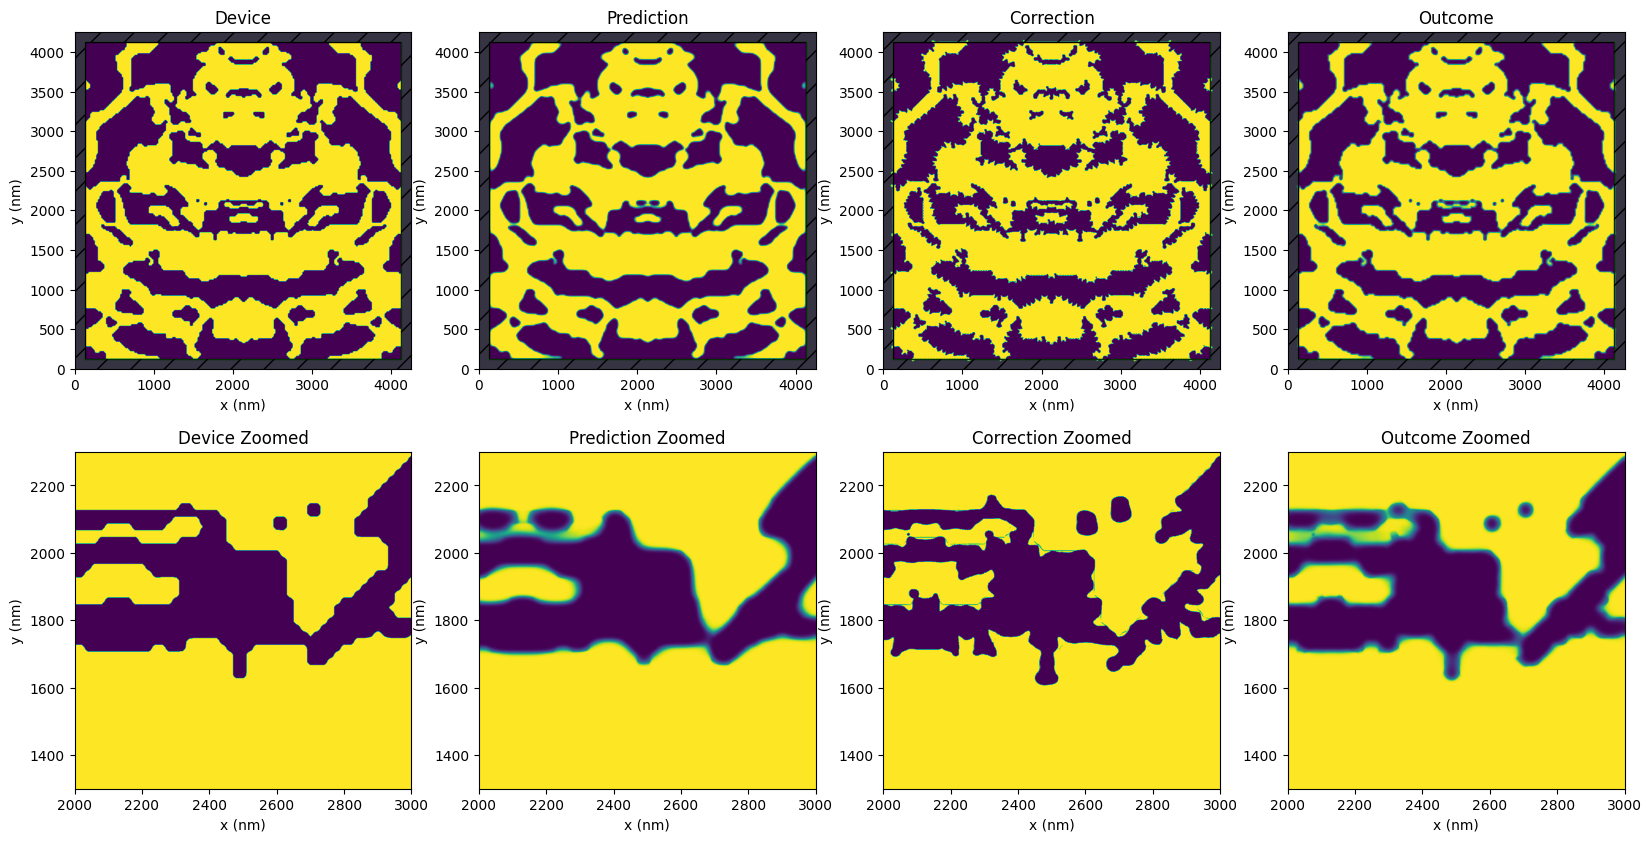

In [10]:
xs, ys, zoom_size = 2000, 1300, 1000
zoom_bounds = ((xs, ys), (xs + zoom_size, ys + zoom_size))
titles = ["Device", "Prediction", "Correction", "Outcome"]
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, (title, data) in enumerate(
    zip(titles, [device, prediction, correction, outcome])
):
    data.plot(ax=axs[0, i])
    axs[0, i].set_title(title)
    data.plot(bounds=zoom_bounds, ax=axs[1, i])
    axs[1, i].set_title(title + " Zoomed")

Below, the images provide a visualization of prediction binarizations at different levels of uncertainty. Notably, binarization at a 50% threshold has the highest probability of occurrence, with the probability decreasing as the threshold moves towards 0% or 100%. By thresholding the raw prediction output, we can see the various potential variations in the design. **The magenta contour overlaid on these images serves as a reference to the original design.**

While we can mitigate this uncertainty somewhat by applying corrections to create larger features, some uncertainty will inevitably remain. In this case, the prediction of the correction (outcome) shows a near-complete restoration, which is quite promising.


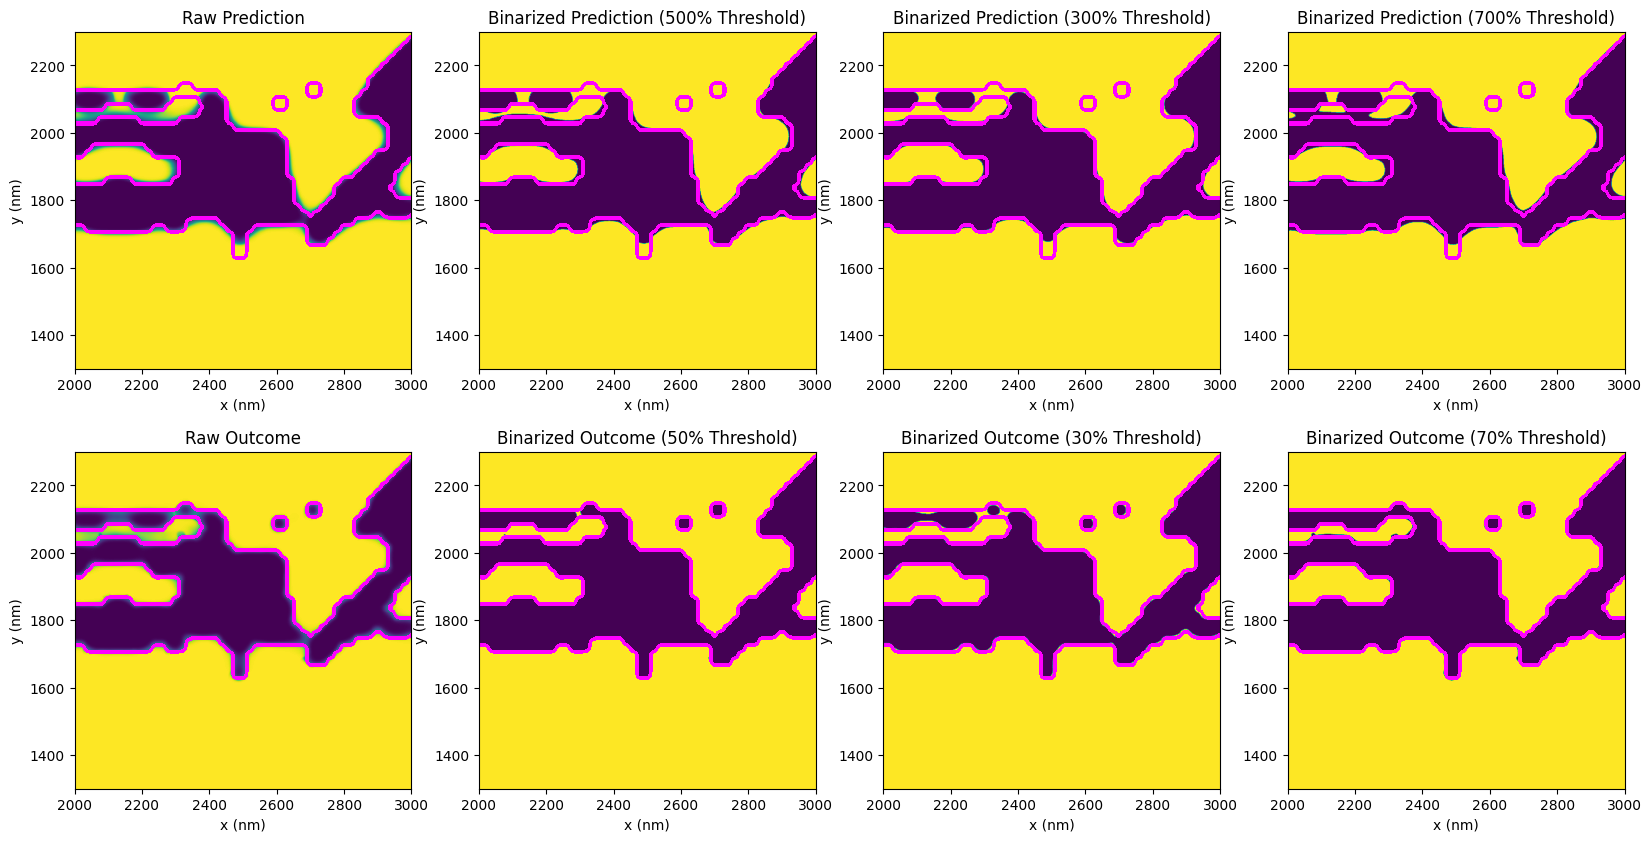

In [11]:
xs, ys, zoom_size = 2000, 1300, 1000
zoom_bounds = ((xs, ys), (xs + zoom_size, ys + zoom_size))
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, eta in enumerate([None, 0.5, 0.3, 0.7]):
    if eta is None:
        axs[0, i].set_title("Raw Prediction")
        axs[1, i].set_title("Raw Outcome")
        prediction.plot(bounds=zoom_bounds, ax=axs[0, i])
        device.plot_contour(
            bounds=zoom_bounds,
            ax=axs[0, i],
            linewidth=16,
        )
        outcome.plot(bounds=zoom_bounds, ax=axs[1, i])
        device.plot_contour(
            bounds=zoom_bounds,
            ax=axs[1, i],
            linewidth=16,
        )
    else:
        axs[0, i].set_title(f"Binarized Prediction ({int(eta*1000)}% Threshold)")
        axs[1, i].set_title(f"Binarized Outcome ({int(eta*100)}% Threshold)")
        prediction.binarize_hard(eta=eta).plot(bounds=zoom_bounds, ax=axs[0, i])
        device.binarize_hard(eta=eta).plot_contour(
            bounds=zoom_bounds,
            ax=axs[0, i],
            linewidth=16,
        )
        outcome.binarize_hard(eta=eta).plot(bounds=zoom_bounds, ax=axs[1, i])
        device.binarize_hard(eta=eta).plot_contour(
            bounds=zoom_bounds,
            ax=axs[1, i],
            linewidth=16,
        )

## Test PreFab predictions in simulation

Next, we will prepare the device variations for re-simulation. To understand the stochastic, or random, variations from one device to another, we will simulate the predictions at different binarization thresholds. This is somewhat akin to uniform erosion and dilation tests, but it is data-driven and varies depending on the feature. Consequently, we will observe less variance for larger features and more variance for smaller ones.


Next, we write a function to simulate a set of devices in parallel using `tidy3d.web.Batch`, which we'll use to analyze the performance over various threshold values.


In [12]:
def run_simulations(
    devices: list[np.ndarray], task_names: list[str]
) -> td.web.BatchData:
    """Construct and run a set of simulations in a batch."""
    sims = {
        task_name: make_simulation(device.to_ndarray())
        for device, task_name in zip(devices, task_names)
    }
    batch = web.Batch(simulations=sims)
    return batch.run(path_dir="data")

In [13]:
etas = list(np.arange(0.2, 0.9, 0.1))

task_names = []
devices = []

# dev simulation
task_names.append("inv_des_gc_dev")
devices.append(device)

# predictions simulations (vs eta)
for eta in etas:
    task_names.append(f"inv_des_gc_pred_bin{int(eta*100)}")
    device_prediction = prediction.binarize_hard(eta=eta)
    devices.append(device_prediction)

# outcome simulations (vs eta)
for eta in etas:
    task_names.append(f"inv_des_gc_out_bin{int(eta*100)}")
    device_outcome = outcome.binarize_hard(eta=eta)
    devices.append(device_outcome)

In [14]:
batch_data = run_simulations(devices=devices, task_names=task_names)

08:40:11 EDT Created task 'inv_des_gc_dev' with task_id                         
             'fdve-1ef8ffb9-decb-456b-ac1f-b0c9e033c34c' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=553465;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1ef8ffb9-decb-456b-ac1f-b0c9e033c34c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=381167;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1ef8ffb9-decb-456b-ac1f-b0c9e033c34c\taskId]8;;\]8;id=553465;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1ef8ffb9-decb-456b-ac1f-b0c9e033c34c\=]8;;\]8;id=195711;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1ef8ffb9-decb-456b-ac1f-b0c9e033c34c\fdve]8;;\]8;id=553465;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1ef8ffb9-decb-456b-ac1f-b0c9e033c34c\-1ef8ffb9-dec]8;;\
             ]8;id=553465;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1ef8ffb9-decb-456b-ac1f-b0c9e033c34c\b-456b-ac1f-b0c9e033c34c']8;;\.

/Users/nugettini/PreFab-Photonics/.venv/prefab/lib/python3.10/site-packages/rich
/live.py:229: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

08:40:13 EDT Created task 'inv_des_gc_pred_bin20' with task_id                  
             'fdve-9dd23334-293d-4624-b84b-94d1ffd14bc8' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=489128;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9dd23334-293d-4624-b84b-94d1ffd14bc8\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=40930;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9dd23334-293d-4624-b84b-94d1ffd14bc8\taskId]8;;\]8;id=489128;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9dd23334-293d-4624-b84b-94d1ffd14bc8\=]8;;\]8;id=947584;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9dd23334-293d-4624-b84b-94d1ffd14bc8\fdve]8;;\]8;id=489128;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9dd23334-293d-4624-b84b-94d1ffd14bc8\-9dd23334-293]8;;\
             ]8;id=489128;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9dd23334-293d-4624-b84b-94d1ffd14bc8\d-4624-b84b-94d1ffd14bc8']8;;\.

08:40:15 EDT Created task 'inv_des_gc_pred_bin30' with task_id                  
             'fdve-56969220-208d-413b-8b66-1903a7a5d811' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=970529;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56969220-208d-413b-8b66-1903a7a5d811\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=818913;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56969220-208d-413b-8b66-1903a7a5d811\taskId]8;;\]8;id=970529;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56969220-208d-413b-8b66-1903a7a5d811\=]8;;\]8;id=823544;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56969220-208d-413b-8b66-1903a7a5d811\fdve]8;;\]8;id=970529;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56969220-208d-413b-8b66-1903a7a5d811\-56969220-208]8;;\
             ]8;id=970529;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56969220-208d-413b-8b66-1903a7a5d811\d-413b-8b66-1903a7a5d811']8;;\.

08:40:18 EDT Created task 'inv_des_gc_pred_bin40' with task_id                  
             'fdve-5ecb4ada-55a7-4801-9012-485ce4ec80b1' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=977808;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5ecb4ada-55a7-4801-9012-485ce4ec80b1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=586341;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5ecb4ada-55a7-4801-9012-485ce4ec80b1\taskId]8;;\]8;id=977808;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5ecb4ada-55a7-4801-9012-485ce4ec80b1\=]8;;\]8;id=958074;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5ecb4ada-55a7-4801-9012-485ce4ec80b1\fdve]8;;\]8;id=977808;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5ecb4ada-55a7-4801-9012-485ce4ec80b1\-5ecb4ada-55a]8;;\
             ]8;id=977808;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5ecb4ada-55a7-4801-9012-485ce4ec80b1\7-4801-9012-485ce4ec80b1']8;;\.

08:40:22 EDT Created task 'inv_des_gc_pred_bin50' with task_id                  
             'fdve-8595fc35-98e4-4cb7-bd2a-7cb9d5c343d6' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=687329;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8595fc35-98e4-4cb7-bd2a-7cb9d5c343d6\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=301325;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8595fc35-98e4-4cb7-bd2a-7cb9d5c343d6\taskId]8;;\]8;id=687329;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8595fc35-98e4-4cb7-bd2a-7cb9d5c343d6\=]8;;\]8;id=573919;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8595fc35-98e4-4cb7-bd2a-7cb9d5c343d6\fdve]8;;\]8;id=687329;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8595fc35-98e4-4cb7-bd2a-7cb9d5c343d6\-8595fc35-98e]8;;\
             ]8;id=687329;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8595fc35-98e4-4cb7-bd2a-7cb9d5c343d6\4-4cb7-bd2a-7cb9d5c343d6']8;;\.

08:40:25 EDT Created task 'inv_des_gc_pred_bin60' with task_id                  
             'fdve-2115d8fe-c0b8-42bc-b1e2-6cac773ed18a' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=724493;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2115d8fe-c0b8-42bc-b1e2-6cac773ed18a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=717067;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2115d8fe-c0b8-42bc-b1e2-6cac773ed18a\taskId]8;;\]8;id=724493;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2115d8fe-c0b8-42bc-b1e2-6cac773ed18a\=]8;;\]8;id=678910;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2115d8fe-c0b8-42bc-b1e2-6cac773ed18a\fdve]8;;\]8;id=724493;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2115d8fe-c0b8-42bc-b1e2-6cac773ed18a\-2115d8fe-c0b]8;;\
             ]8;id=724493;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2115d8fe-c0b8-42bc-b1e2-6cac773ed18a\8-42bc-b1e2-6cac773ed18a']8;;\.

08:40:28 EDT Created task 'inv_des_gc_pred_bin70' with task_id                  
             'fdve-02016a28-e796-43af-a022-c6dc5d8e6e09' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=101791;https://tidy3d.simulation.cloud/workbench?taskId=fdve-02016a28-e796-43af-a022-c6dc5d8e6e09\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=955554;https://tidy3d.simulation.cloud/workbench?taskId=fdve-02016a28-e796-43af-a022-c6dc5d8e6e09\taskId]8;;\]8;id=101791;https://tidy3d.simulation.cloud/workbench?taskId=fdve-02016a28-e796-43af-a022-c6dc5d8e6e09\=]8;;\]8;id=877022;https://tidy3d.simulation.cloud/workbench?taskId=fdve-02016a28-e796-43af-a022-c6dc5d8e6e09\fdve]8;;\]8;id=101791;https://tidy3d.simulation.cloud/workbench?taskId=fdve-02016a28-e796-43af-a022-c6dc5d8e6e09\-02016a28-e79]8;;\
             ]8;id=101791;https://tidy3d.simulation.cloud/workbench?taskId=fdve-02016a28-e796-43af-a022-c6dc5d8e6e09\6-43af-a022-c6dc5d8e6e09']8;;\.

08:40:30 EDT Created task 'inv_des_gc_pred_bin80' with task_id                  
             'fdve-54c2c91d-b365-447c-88ae-2d7e69c1522e' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=367270;https://tidy3d.simulation.cloud/workbench?taskId=fdve-54c2c91d-b365-447c-88ae-2d7e69c1522e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=249989;https://tidy3d.simulation.cloud/workbench?taskId=fdve-54c2c91d-b365-447c-88ae-2d7e69c1522e\taskId]8;;\]8;id=367270;https://tidy3d.simulation.cloud/workbench?taskId=fdve-54c2c91d-b365-447c-88ae-2d7e69c1522e\=]8;;\]8;id=772329;https://tidy3d.simulation.cloud/workbench?taskId=fdve-54c2c91d-b365-447c-88ae-2d7e69c1522e\fdve]8;;\]8;id=367270;https://tidy3d.simulation.cloud/workbench?taskId=fdve-54c2c91d-b365-447c-88ae-2d7e69c1522e\-54c2c91d-b36]8;;\
             ]8;id=367270;https://tidy3d.simulation.cloud/workbench?taskId=fdve-54c2c91d-b365-447c-88ae-2d7e69c1522e\5-447c-88ae-2d7e69c1522e']8;;\.

08:40:32 EDT Created task 'inv_des_gc_out_bin20' with task_id                   
             'fdve-56b6fc15-521b-40cb-9c67-77961ef72b46' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=88347;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56b6fc15-521b-40cb-9c67-77961ef72b46\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=770020;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56b6fc15-521b-40cb-9c67-77961ef72b46\taskId]8;;\]8;id=88347;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56b6fc15-521b-40cb-9c67-77961ef72b46\=]8;;\]8;id=457134;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56b6fc15-521b-40cb-9c67-77961ef72b46\fdve]8;;\]8;id=88347;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56b6fc15-521b-40cb-9c67-77961ef72b46\-56b6fc15-521]8;;\
             ]8;id=88347;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56b6fc15-521b-40cb-9c67-77961ef72b46\b-40cb-9c67-77961ef72b46']8;;\.

08:40:34 EDT Created task 'inv_des_gc_out_bin30' with task_id                   
             'fdve-d6e76062-9e67-430f-97a1-d5b6a70abfc6' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=183233;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d6e76062-9e67-430f-97a1-d5b6a70abfc6\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=213627;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d6e76062-9e67-430f-97a1-d5b6a70abfc6\taskId]8;;\]8;id=183233;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d6e76062-9e67-430f-97a1-d5b6a70abfc6\=]8;;\]8;id=877900;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d6e76062-9e67-430f-97a1-d5b6a70abfc6\fdve]8;;\]8;id=183233;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d6e76062-9e67-430f-97a1-d5b6a70abfc6\-d6e76062-9e6]8;;\
             ]8;id=183233;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d6e76062-9e67-430f-97a1-d5b6a70abfc6\7-430f-97a1-d5b6a70abfc6']8;;\.

08:40:36 EDT Created task 'inv_des_gc_out_bin40' with task_id                   
             'fdve-349f3348-a1db-4859-8abf-57fe61a9c42e' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=580815;https://tidy3d.simulation.cloud/workbench?taskId=fdve-349f3348-a1db-4859-8abf-57fe61a9c42e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=41784;https://tidy3d.simulation.cloud/workbench?taskId=fdve-349f3348-a1db-4859-8abf-57fe61a9c42e\taskId]8;;\]8;id=580815;https://tidy3d.simulation.cloud/workbench?taskId=fdve-349f3348-a1db-4859-8abf-57fe61a9c42e\=]8;;\]8;id=639836;https://tidy3d.simulation.cloud/workbench?taskId=fdve-349f3348-a1db-4859-8abf-57fe61a9c42e\fdve]8;;\]8;id=580815;https://tidy3d.simulation.cloud/workbench?taskId=fdve-349f3348-a1db-4859-8abf-57fe61a9c42e\-349f3348-a1d]8;;\
             ]8;id=580815;https://tidy3d.simulation.cloud/workbench?taskId=fdve-349f3348-a1db-4859-8abf-57fe61a9c42e\b-4859-8abf-57fe61a9c42e']8;;\.

08:40:38 EDT Created task 'inv_des_gc_out_bin50' with task_id                   
             'fdve-77689ee2-29d9-4944-af5f-eaa93a688e40' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=503167;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77689ee2-29d9-4944-af5f-eaa93a688e40\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=982618;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77689ee2-29d9-4944-af5f-eaa93a688e40\taskId]8;;\]8;id=503167;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77689ee2-29d9-4944-af5f-eaa93a688e40\=]8;;\]8;id=990220;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77689ee2-29d9-4944-af5f-eaa93a688e40\fdve]8;;\]8;id=503167;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77689ee2-29d9-4944-af5f-eaa93a688e40\-77689ee2-29d]8;;\
             ]8;id=503167;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77689ee2-29d9-4944-af5f-eaa93a688e40\9-4944-af5f-eaa93a688e40']8;;\.

08:40:40 EDT Created task 'inv_des_gc_out_bin60' with task_id                   
             'fdve-80aafa83-251a-4ecc-b9f5-c586202f2127' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=597851;https://tidy3d.simulation.cloud/workbench?taskId=fdve-80aafa83-251a-4ecc-b9f5-c586202f2127\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=169580;https://tidy3d.simulation.cloud/workbench?taskId=fdve-80aafa83-251a-4ecc-b9f5-c586202f2127\taskId]8;;\]8;id=597851;https://tidy3d.simulation.cloud/workbench?taskId=fdve-80aafa83-251a-4ecc-b9f5-c586202f2127\=]8;;\]8;id=507221;https://tidy3d.simulation.cloud/workbench?taskId=fdve-80aafa83-251a-4ecc-b9f5-c586202f2127\fdve]8;;\]8;id=597851;https://tidy3d.simulation.cloud/workbench?taskId=fdve-80aafa83-251a-4ecc-b9f5-c586202f2127\-80aafa83-251]8;;\
             ]8;id=597851;https://tidy3d.simulation.cloud/workbench?taskId=fdve-80aafa83-251a-4ecc-b9f5-c586202f2127\a-4ecc-b9f5-c586202f2127']8;;\.

08:40:41 EDT Created task 'inv_des_gc_out_bin70' with task_id                   
             'fdve-83faf9b0-8f75-4d51-8fe4-fca57a2a90d7' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=113999;https://tidy3d.simulation.cloud/workbench?taskId=fdve-83faf9b0-8f75-4d51-8fe4-fca57a2a90d7\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=590358;https://tidy3d.simulation.cloud/workbench?taskId=fdve-83faf9b0-8f75-4d51-8fe4-fca57a2a90d7\taskId]8;;\]8;id=113999;https://tidy3d.simulation.cloud/workbench?taskId=fdve-83faf9b0-8f75-4d51-8fe4-fca57a2a90d7\=]8;;\]8;id=80251;https://tidy3d.simulation.cloud/workbench?taskId=fdve-83faf9b0-8f75-4d51-8fe4-fca57a2a90d7\fdve]8;;\]8;id=113999;https://tidy3d.simulation.cloud/workbench?taskId=fdve-83faf9b0-8f75-4d51-8fe4-fca57a2a90d7\-83faf9b0-8f7]8;;\
             ]8;id=113999;https://tidy3d.simulation.cloud/workbench?taskId=fdve-83faf9b0-8f75-4d51-8fe4-fca57a2a90d7\5-4d51-8fe4-fca57a2a90d7']8;;\.

08:40:43 EDT Created task 'inv_des_gc_out_bin80' with task_id                   
             'fdve-1ff5c431-5412-4502-b2da-611e5e03b1a7' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=202029;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1ff5c431-5412-4502-b2da-611e5e03b1a7\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=45364;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1ff5c431-5412-4502-b2da-611e5e03b1a7\taskId]8;;\]8;id=202029;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1ff5c431-5412-4502-b2da-611e5e03b1a7\=]8;;\]8;id=726452;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1ff5c431-5412-4502-b2da-611e5e03b1a7\fdve]8;;\]8;id=202029;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1ff5c431-5412-4502-b2da-611e5e03b1a7\-1ff5c431-541]8;;\
             ]8;id=202029;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1ff5c431-5412-4502-b2da-611e5e03b1a7\2-4502-b2da-611e5e03b1a7']8;;\.

08:41:04 EDT Started working on Batch.

08:42:26 EDT Maximum FlexCredit cost: 2.890 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

08:42:32 EDT Batch complete.

In [15]:
# extract the various sim_data from the batch data output
sim_data_dev = batch_data["inv_des_gc_dev"]
sim_data_pred = {eta: batch_data[f"inv_des_gc_pred_bin{int(eta*100)}"] for eta in etas}
sim_data_out = {eta: batch_data[f"inv_des_gc_out_bin{int(eta*100)}"] for eta in etas}

08:42:36 EDT loading simulation from                                            
             data/fdve-1ef8ffb9-decb-456b-ac1f-b0c9e033c34c.hdf5

/Users/nugettini/PreFab-Photonics/.venv/prefab/lib/python3.10/site-packages/rich
/live.py:229: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

08:42:39 EDT loading simulation from                                            
             data/fdve-9dd23334-293d-4624-b84b-94d1ffd14bc8.hdf5

/Users/nugettini/PreFab-Photonics/.venv/prefab/lib/python3.10/site-packages/rich
/live.py:229: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

08:42:42 EDT loading simulation from                                            
             data/fdve-56969220-208d-413b-8b66-1903a7a5d811.hdf5

/Users/nugettini/PreFab-Photonics/.venv/prefab/lib/python3.10/site-packages/rich
/live.py:229: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

08:42:45 EDT loading simulation from                                            
             data/fdve-5ecb4ada-55a7-4801-9012-485ce4ec80b1.hdf5

/Users/nugettini/PreFab-Photonics/.venv/prefab/lib/python3.10/site-packages/rich
/live.py:229: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

08:42:47 EDT loading simulation from                                            
             data/fdve-8595fc35-98e4-4cb7-bd2a-7cb9d5c343d6.hdf5

/Users/nugettini/PreFab-Photonics/.venv/prefab/lib/python3.10/site-packages/rich
/live.py:229: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

08:42:50 EDT loading simulation from                                            
             data/fdve-2115d8fe-c0b8-42bc-b1e2-6cac773ed18a.hdf5

/Users/nugettini/PreFab-Photonics/.venv/prefab/lib/python3.10/site-packages/rich
/live.py:229: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

08:42:54 EDT loading simulation from                                            
             data/fdve-02016a28-e796-43af-a022-c6dc5d8e6e09.hdf5

/Users/nugettini/PreFab-Photonics/.venv/prefab/lib/python3.10/site-packages/rich
/live.py:229: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

08:42:56 EDT loading simulation from                                            
             data/fdve-54c2c91d-b365-447c-88ae-2d7e69c1522e.hdf5

/Users/nugettini/PreFab-Photonics/.venv/prefab/lib/python3.10/site-packages/rich
/live.py:229: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

08:42:59 EDT loading simulation from                                            
             data/fdve-56b6fc15-521b-40cb-9c67-77961ef72b46.hdf5

/Users/nugettini/PreFab-Photonics/.venv/prefab/lib/python3.10/site-packages/rich
/live.py:229: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

08:43:02 EDT loading simulation from                                            
             data/fdve-d6e76062-9e67-430f-97a1-d5b6a70abfc6.hdf5

/Users/nugettini/PreFab-Photonics/.venv/prefab/lib/python3.10/site-packages/rich
/live.py:229: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

08:43:05 EDT loading simulation from                                            
             data/fdve-349f3348-a1db-4859-8abf-57fe61a9c42e.hdf5

/Users/nugettini/PreFab-Photonics/.venv/prefab/lib/python3.10/site-packages/rich
/live.py:229: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

08:43:08 EDT loading simulation from                                            
             data/fdve-77689ee2-29d9-4944-af5f-eaa93a688e40.hdf5

/Users/nugettini/PreFab-Photonics/.venv/prefab/lib/python3.10/site-packages/rich
/live.py:229: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

08:43:11 EDT loading simulation from                                            
             data/fdve-80aafa83-251a-4ecc-b9f5-c586202f2127.hdf5

/Users/nugettini/PreFab-Photonics/.venv/prefab/lib/python3.10/site-packages/rich
/live.py:229: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

08:43:14 EDT loading simulation from                                            
             data/fdve-83faf9b0-8f75-4d51-8fe4-fca57a2a90d7.hdf5

/Users/nugettini/PreFab-Photonics/.venv/prefab/lib/python3.10/site-packages/rich
/live.py:229: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

08:43:16 EDT loading simulation from                                            
             data/fdve-1ff5c431-5412-4502-b2da-611e5e03b1a7.hdf5

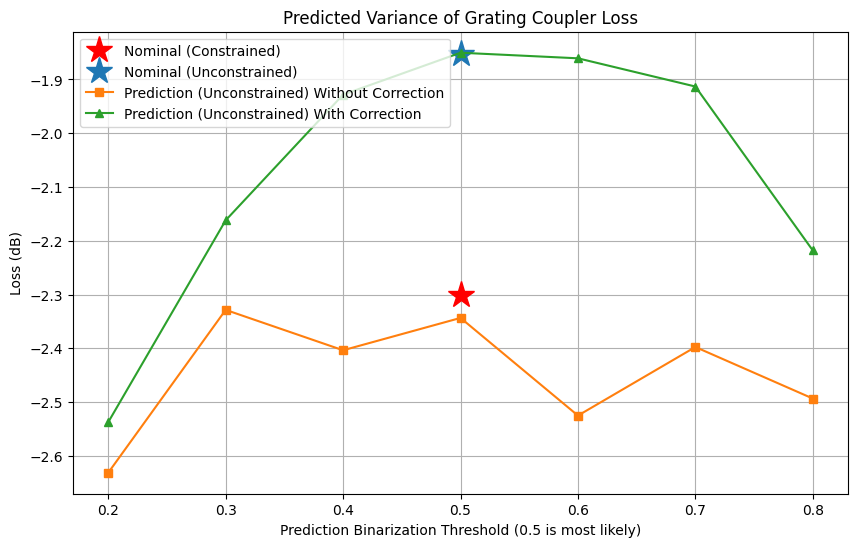

In [16]:
def calculate_loss(sim_data_dict: dict) -> dict:
    """Extract the loss (dB) from the simulation data results."""
    loss_db_dict = {}
    for eta, sim_data in sim_data_dict.items():
        mode_amps = sim_data["gc_efficiency"]
        coeffs_f = mode_amps.amps.sel(direction="-")
        power_0 = np.abs(coeffs_f.sel(mode_index=0)) ** 2
        power_0_db = 10 * np.log10(power_0)
        loss_db = max(power_0_db)
        loss_db_dict[eta] = loss_db
    return loss_db_dict


loss_db_dev = calculate_loss({0.5: sim_data_dev})
loss_db_pred = calculate_loss(sim_data_pred)
loss_db_out = calculate_loss(sim_data_out)

etas = list(loss_db_pred.keys())
etas_dev = [0.5]
losses_pred = [loss_db_pred[eta] for eta in etas]
losses_out = [loss_db_out[eta] for eta in etas]
losses_dev = [loss_db_dev[0.5]]
losses_orig = [-2.30]

plt.figure(figsize=(10, 6))
plt.plot(0.5, losses_orig[0], "r*", label="Nominal (Constrained)", markersize=20)
plt.plot(etas_dev, losses_dev, "*", label="Nominal (Unconstrained)", markersize=20)
plt.plot(etas, losses_pred, "s-", label="Prediction (Unconstrained) Without Correction")
plt.plot(etas, losses_out, "^-", label="Prediction (Unconstrained) With Correction")
plt.xlabel("Prediction Binarization Threshold (0.5 is most likely)")
plt.ylabel("Loss (dB)")
plt.title("Predicted Variance of Grating Coupler Loss")
plt.legend()
plt.grid(True)
plt.show()

The optimization process without constraints has significantly enhanced performance, achieving a lower loss of -1.85 dB compared to the -2.30 dB observed in the previous notebook. However, when considering predicted variations, the performance of this new design slightly deteriorates to -2.34 dB. Nevertheless, by applying specific corrections, we demonstrate that the anticipated chip-level performance can be restored back to -1.85 dB. Through the adjustment of the binarization threshold within the uncertainty range of the predictions, we are able to assess the expected variance between devices. This not only underscores the substantial advantages of PreFab correction but also deepens our comprehension of the fabrication process's capabilities.


Use the following code block to export your predictions and corrections. This will write the refined design into a new cell in the original GDS file located in `misc/`.


In [25]:
import gdstk

gds_library = gdstk.read_gds(infile=GDS_FILE)

device_cell = device.to_gdstk(cell_name="gc_device", gds_layer=(1, 0))
prediction_cell = prediction.binarize().to_gdstk(
    cell_name="gc_prediction", gds_layer=(9, 0)
)
correction_cell = correction.to_gdstk(
    cell_name="gc_correction", gds_layer=(90, 0), contour_approx_mode=3
)
outcome_cell = outcome.binarize().to_gdstk(cell_name="gc_outcome", gds_layer=(800, 0))

gc_cell = gds_library.new_cell(GDS_CELL_FINAL)
gds_library.add(prediction_cell)
gds_library.add(correction_cell)
gds_library.add(outcome_cell)
gds_library.add(device_cell)
origin = (-prediction.shape[1] / 2 / 1000, -prediction.shape[0] / 2 / 1000)
gds_library[GDS_CELL_FINAL].add(gdstk.Reference(cell=device_cell, origin=origin))
gds_library[GDS_CELL_FINAL].add(gdstk.Reference(cell=prediction_cell, origin=origin))
gds_library[GDS_CELL_FINAL].add(gdstk.Reference(cell=correction_cell, origin=origin))
gds_library[GDS_CELL_FINAL].add(gdstk.Reference(cell=outcome_cell, origin=origin))
gds_library.write_gds(outfile=GDS_FILE, max_points=8190)

Creating cell 'gc_device'...
Creating cell 'gc_prediction'...
Creating cell 'gc_correction'...
Creating cell 'gc_outcome'...


If you're interested in learning more about PreFab, please visit the [website](https://www.prefabphotonics.com/) and [GitHub page](https://github.com/PreFab-Photonics). There, you'll find more resources and examples to help you get the most out of the tools.
